In [208]:
import tensorflow as tf
import os
from ml_metadata.metadata_store import metadata_store
from ml_metadata.proto import metadata_store_pb2
from ml_metadata.proto import metadata_store_service_pb2
from tensorflow.python.lib.io import file_io  # pylint: disable=g-direct-tensorflow-import
from tfx.orchestration import data_types
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.types import artifact_utils
from tfx.types.artifact import Artifact
from tfx.types.artifact import ArtifactState

In [209]:
_pipeline_name = 'chicago_taxi_beam'
_tfx_root = os.path.join(os.environ['HOME'], 'tfx')
metadata_path = os.path.join(_tfx_root, 'metadata', _pipeline_name, 'metadata.db')

In [210]:
mlmd_config = metadata.sqlite_metadata_connection_config(metadata_path)

In [211]:
connection = metadata.Metadata(mlmd_config)
store = metadata_store.MetadataStore(mlmd_config)

INFO:absl:MetadataStore with DB connection initialized


In [212]:
artifacts = store.get_artifacts()

In [213]:
artifact_ids = [art.id for art in artifacts]
labeled_artifact_ids = [f'a{id}' for id in artifact_ids]

In [214]:
executions = store.get_executions()
#filter executions with state = "complete"


In [215]:
execution_ids = [exec.id for exec in executions if exec.properties['state'].string_value == 'complete']
labeled_execution_ids = [f'e{id}' for id in execution_ids]

In [216]:
events = store.get_events_by_execution_ids(execution_ids)

In [217]:
event_id_pairs = [(f'a{event.artifact_id}', f'e{event.execution_id}') for event in events]

In [218]:
import ipycytoscape
import ipywidgets as widgets
import networkx as nx

In [219]:
graph = nx.Graph()

In [220]:
graph.add_edges_from(event_id_pairs)

In [221]:
def get_color(node):
    if 'e' in node:
        return (0.529,0.808,0.922)
    else:
        return (0,1,0)

In [222]:
pos = nx.spring_layout(graph)

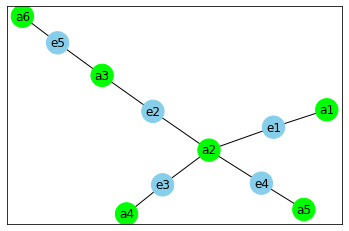

In [223]:
nx.draw_networkx_nodes(graph, pos, node_color=[get_color(node) for node in graph.nodes()], node_size=500)
nx.draw_networkx_labels(graph, pos)
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), arrows=False)

In [224]:
graph2 = nx.Graph()
graph2.add_edges_from(event_id_pairs)
graph2.add_nodes_from(labeled_artifact)

NameError: name 'labeled_artifact' is not defined

In [ ]:
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_networkx(graph)

In [ ]:
cytoscapeobj